### Set up environment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
def calculate_ccdf_wetvalues(precipitation_data, bins_i_want, filter_small_vals=False):
    # Remove NAN values
    precipitation_data = precipitation_data[~np.isnan(precipitation_data)]
    # Keep only wet values 
    precipitation_data = precipitation_data[precipitation_data >= 0.1]
    
    if filter_small_vals:
        precipitation_data = precipitation_data[(precipitation_data >= 0.5) & (precipitation_data <= 1.5)]
    
    # Compute the cumulative distribution function (CDF) using the histogram
    # np.diff(bin_edges): Calculate the differences between bin edges to get bin widths
    # hist * np.diff(bin_edges): Multiply each histogram value by its corresponding bin width
    # np.cumsum(): Compute the cumulative sum of the products
    # cdf: The cumulative distribution function values
    hist, bin_edges = np.histogram(precipitation_data, bins=bins_i_want, density=True)
    cdf = np.cumsum(hist * np.diff(bin_edges))
    
    # Calculate 1 - CDF for CCDF
    ccdf = 1 - cdf
    
    # Find the centre point of each bin for plotting
    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    return cdf, ccdf, bin_centres

# Function to calculate PDF from a single file
def calculate_pdf_wetvalues (precipitation_data,bins_i_want, filter_small_vals=False ):
    # Remove NAN values
    precipitation_data = precipitation_data[~np.isnan(precipitation_data)]
    # Keep only wet values 
    precipitation_data = precipitation_data[precipitation_data >= 0.1]
    
    if filter_small_vals == True:
        precipitation_data = precipitation_data[precipitation_data >= 0.5]
        precipitation_data = precipitation_data[precipitation_data <= 1.5]
    
    freqs, bin_edges = np.histogram(precipitation_data, bins=bins_i_want, density=True)
    # I think this was just for knowing how many value was in each bin
    # How was I using that in log_discrete_histogram_less_legend???
    # freqs_numbers, bin_edges = np.histogram(precipitation_data, bins= bins, density=False)
    
    # Find the centre point of each bin for plotting
    bin_centres =  0.5*(bin_edges[1:] + bin_edges[:-1])    
    
    return freqs, bin_centres

In [4]:
resolution = '12km'

### Get observations data for overlapping and not overlapping time periods

In [5]:
obs_data_overlap = np.array([])
obs_data_no_overlap = np.array([])

datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/'

for yr in range(1990,2014):
    file_name = datadir + f"{yr}_compressed.npy"
    this_yr = np.load(file_name)
    obs_data_no_overlap =np.append(obs_data_no_overlap, this_yr)
    if yr >=1990 and yr <=2001:
         obs_data_overlap =np.append(obs_data_overlap, this_yr)

### Get model data for overlapping and not overlapping time periods

In [8]:
ems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']

model_data_overlap = np.array([])
model_data_no_overlap = np.array([])
for em in ems:
    print(em)
    datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_hourly/2.2km_regridded_12km/1980_2001/{em}/'
    for yr in range(1981,2001):
        file_name = datadir + f"compressed_{yr}.npy"
        this_yr = np.load(file_name)
        model_data_no_overlap =np.append(model_data_no_overlap, this_yr)
        if yr >=1990 and yr <=2001:
            model_data_overlap =np.append(model_data_overlap, this_yr)

01
04
05
06
07
08
09
10
11
12
13
15


### Plot

In [10]:
combined_numbers=model_data_overlap

In [ ]:
#!/usr/bin/env python
# Steven Boeing, 2020
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# EXAMPLE CODES REGARDING PROBABILITY DISTRIBUTION FUNCTION
# AND CUMULATIVE DISTRIBUTION FUNCTION PLOTTING 

# SMALL NOTES
# 1) This shows some possibilities for plotting, but there are more
# possibilities (e.g. a weighted cumulative distribution function).
# 2) I may want to add something about handling of zero/small values in the
# normalisation procedure at some point. It is something to think about,
# see Nikolina Ban's work.
# 3) I think numpy.histogram and mpl.hist handle numbers that are exactly
# on a bin edge sligthly differently, and it is still possible to improve
# the handling of cases where not all the numbers are in a bin.

# RANDOM NUMBER GENERATION FOR PLOTS
# The seed function is used to make sure you draw the same 'random' 
# numbers each time.
# Draw numbers from a lognormal and from a beta distribution, 
# combine these into a single array
draws_in_each_distribution=10000
np.random.seed(21)
lognormal_numbers=np.random.lognormal(mean=0.3, sigma=1.0, size=draws_in_each_distribution)
beta_numbers=np.random.lognormal(mean=0.3, sigma=0.5, size=draws_in_each_distribution)
combined_numbers=np.concatenate((lognormal_numbers,beta_numbers))
total_nr_draws=len(combined_numbers)

# PARAMETERS FOR PLOTTING HISTOGRAMS
# Parameters to generate bins with unequal spacing
# We use an approach based on the N-th power here 
# (advantage over logarithmic spacing: easy to handle near-zero values)
# An alternative is to use a logarithmmic spacing (see lower down)
number_many_linear_bins=200 # Number of bins for improved plots with equal bins
power_for_unequal_bins=3.0 # Power used for generating unequal bins
number_unequal_bins=40 # Number of unequal bins 
unequal_min=0. # Must be zero or bigger for this approach to work
unequal_max=1.01*np.nanmax(combined_numbers) # Ensure this is greater than the largest number
# N-th root (e.g. third root) of bin edges for manual bin edge spacing
unequal_linspace=np.linspace(unequal_min,unequal_max**(1.0/power_for_unequal_bins),number_unequal_bins) 
unequal_bin_edges=unequal_linspace**power_for_unequal_bins
# This piece of codes calculates the bin centres, based on the third root
# Alternative choice would be: power_bin_centres=0.5*(unequal_bin_edges[:-1]+unequal_bin_edges[1:])
unequal_linspace_centres=0.5*(unequal_linspace[:-1]+unequal_linspace[1:])
unequal_bin_centres=(unequal_linspace_centres)**3

# BEFORE PLOTTING, CHECK MATPLOTLIB VERSION JUST TO SEE WE CAN PLOT EVERYTHING
# USING TUPLES TO AVOID DEPENDECY ON PACKAGES
def versiontuple(v):
    return tuple(map(int, (v.split("."))))
    
if (versiontuple(mpl.__version__)<versiontuple("2.0.0")):
    print 'Error: density histograms need a version of matplotlib>2.0.0'
    print 'You may want to set up and activate an appropriate anaconda environment'
    quit()
    
# SIMPLE HISTOGRAMS
plt.hist(combined_numbers)
plt.title('simple histogram with few bins (take note of y-axis maximum)')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()

plt.hist(combined_numbers,bins=200)
plt.title(str(number_many_linear_bins)+' bins (fewer counts per bin)')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()

# Shows hit-and-miss behaviour for higher values
plt.hist(combined_numbers,bins=200)
plt.title(str(number_many_linear_bins)+' bins, zooming in on the higher values')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.ylim(0,20)
plt.show()

plt.hist(combined_numbers,bins=unequal_bin_edges)
plt.title('using unequal bin widths, the curve becomes smoother')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()

# INTRODUCING THE DENSITY ARGUMENT
# Motivation
plt.hist(combined_numbers,bins=200,histtype='step')
plt.hist(combined_numbers,bins=unequal_bin_edges,histtype='step')
plt.legend((str(number_many_linear_bins)+' equal bins',str(number_unequal_bins)+' unequal bins'))
plt.title('caution: unequal bins influence shape of the curve (histtype=\'step\')')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()

plt.hist(combined_numbers,histtype='step',density=True)
plt.hist(combined_numbers,bins=200,histtype='step',density=True)
plt.hist(combined_numbers,bins=unequal_bin_edges,histtype='step',density=True)
plt.legend(('few bins',str(number_many_linear_bins)+' equal bins',str(number_unequal_bins)+' unequal bins'))
plt.title('use \'density\' argument to normalise y-axis (area under each curve is 1)')
plt.xlabel('bin value')
plt.ylabel('density of counts (area under curve is 1)')
plt.ylim(0,0.6)
plt.show()

plt.hist(combined_numbers,histtype='step',density=True)
plt.hist(combined_numbers,bins=200,histtype='step',density=True)
plt.hist(combined_numbers,bins=unequal_bin_edges,histtype='step',density=True)
plt.legend(('few bins',str(number_many_linear_bins)+' equal bins',str(number_unequal_bins)+' unequal bins'))
plt.title('zooming in on the distributions with the \'density\' argument')
plt.xlabel('bin value')
plt.ylabel('density of counts (area under curve is 1)')
plt.ylim(0,0.01)
plt.show()

# NUMPY CALCULATIONS OF HISTOGRAM
# Use extended arrays to get edges right using matplotlib.pyplot.step
# Check manual plots against matplotlib.pyplot.hist
# In the examples below, the 'where' argument is added explicitly
# For the cumulative distribution functions, add extra bin equal to last value
def extend_histogram(values,bin_edges,cumulative=False):
    if cumulative==True:
        return np.concatenate(([0.0],values,[values[-1]])),np.concatenate((bin_edges,[bin_edges[-1]]))      
    else:
        return np.concatenate(([0.0],values,[0.0])),np.concatenate((bin_edges,[bin_edges[-1]]))
    
unequal_density,bins_out=np.histogram(combined_numbers,bins=unequal_bin_edges,density=True)
unequal_density_extended,unequal_bin_edges_extended=extend_histogram(unequal_density,unequal_bin_edges)

# PLOTS TO CHECK MANUALLY PLOTTED HISTOGRAMS AGAINST MATPLOTLIB ONES
plt.plot(unequal_bin_centres,unequal_density)
plt.step(unequal_bin_edges_extended,unequal_density_extended,where='pre') 
plt.hist(combined_numbers,bins=unequal_bin_edges,density=True)
plt.legend(('plotted as lines','plotted as steps','plotted with matplotlib'))
plt.title('you can plot as lines as well (needs some more code)')
plt.xlabel('bin value')
plt.ylabel('density of counts (area under curve is 1)')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,0.6)
plt.show()

plt.plot(unequal_bin_centres,unequal_density)
plt.step(unequal_bin_edges_extended,unequal_density_extended,where='pre')
plt.hist(combined_numbers,bins=unequal_bin_edges,density=True)
plt.legend(('plotted as lines','plotted as steps','plotted with matplotlib'))
plt.title('zooming in on smaller values')
plt.xlabel('bin value')
plt.ylabel('density of counts (area under curve is 1)')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,0.01)
plt.show()

# For the logarithmic plots, add scatterplot option
# Drawback of this plot is that the area under the curve no longer
# corresponds to anything
plt.plot(unequal_bin_centres,unequal_density)
plt.step(unequal_bin_edges_extended,unequal_density_extended,where='pre')
plt.scatter(unequal_bin_centres,unequal_density)
plt.hist(combined_numbers,bins=unequal_bin_edges,density=True)
plt.legend(('plotted as lines','plotted as steps','plotted as scatterplot','plotted with matplotlib'))
plt.title('using a y log-axis')
plt.xlabel('bin value')
plt.ylabel('density of counts (log axis)')
plt.gca().set_yscale('log')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(1e-5,1.0)
plt.show()

plt.plot(unequal_bin_centres,unequal_density)
plt.step(unequal_bin_edges_extended,unequal_density_extended,where='pre')
plt.scatter(unequal_bin_centres,unequal_density)
plt.hist(combined_numbers,bins=unequal_bin_edges,density=True)
plt.legend(('plotted as lines','plotted as steps','plotted as scatterplot','plotted with matplotlib'))
plt.title('using two log axes')
plt.xlabel('bin value (log axis)')
plt.ylabel('density of counts (log axis)')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim(1e-3,np.nanmax(combined_numbers))
plt.ylim(1e-5,1.0)
plt.show()

# CUMULATIVE HISTOGRAM PLOTTING
# Including manual normalisation
# Extended arrays used to make cdf go from 0 to non-zero at first value in line plot
# Another (nicer) way to create cdfs involves sorting the array to obtain relative ranks
# this is also demonstrated
unequal_counts,bins_out=np.histogram(combined_numbers,bins=unequal_bin_edges) 
unequal_cumulative=np.cumsum(unequal_counts)/(1.0*total_nr_draws)
unequal_cumulative_extended,unequal_bin_edges_extended=extend_histogram(unequal_cumulative,unequal_bin_edges,cumulative=True)
sorted_numbers = np.sort(combined_numbers)
sorted_numbers_extended=np.concatenate(([sorted_numbers[0]],sorted_numbers)) # repeat first number as zero entry
relative_ranks=np.arange(total_nr_draws+1.0)/(1.0*total_nr_draws)
exceedance_ranks=1.0-relative_ranks

plt.plot(unequal_bin_edges_extended,unequal_cumulative_extended)
plt.step(unequal_bin_edges_extended,unequal_cumulative_extended,where='pre')
plt.hist(combined_numbers,bins=unequal_bin_edges,cumulative=True,density=True)
plt.legend(('plotted as lines','plotted as steps','plotted with matplotlib'))
plt.title('instead of pdfs, plot cumulative distributions (lines meet at right of bar)')
plt.xlabel('bin value')
plt.ylabel('fraction of contributions below bin value')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,1.0)
plt.show()

plt.plot(sorted_numbers_extended,relative_ranks)
plt.hist(combined_numbers,bins=unequal_bin_edges,cumulative=True,density=True)
plt.legend(('plotted as lines','plotted with matplotlib'))
plt.title('nicer cdfs can be obtained using a sorting approach')
plt.xlabel('bin value')
plt.ylabel('fraction of contributions below bin value')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,1.0)
plt.show()

plt.plot(sorted_numbers_extended,exceedance_ranks)
plt.title('probability of exceedance (1-cdf value)')
plt.xlabel('bin value')
plt.ylabel('probability of exceedance')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,1.0)
plt.show()

plt.plot(sorted_numbers_extended,exceedance_ranks)
plt.scatter(sorted_numbers_extended,exceedance_ranks)
plt.legend(('plotted as lines','plotted as a scatterplot'))
plt.title('using a y-log axis')
plt.xlabel('bin value')
plt.ylabel('probability of exceedance')
plt.gca().set_yscale('log')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(1e-5,1.0)
plt.show()

# WEIGHTED DENSITY HISTOGRAMS
# Rather than probability in each bin, these show the contribution to the
# sum of the numbers corresponding to each bin.
weighted_density,bins_out=np.histogram(combined_numbers,bins=unequal_bin_edges,density=True,weights=combined_numbers)
weighted_density_extended,unequal_bin_edges_extended=extend_histogram(weighted_density,unequal_bin_edges)
  
plt.plot(unequal_bin_centres,weighted_density)
plt.step(unequal_bin_edges_extended,weighted_density_extended,where='pre')
plt.hist(combined_numbers,bins=unequal_bin_edges,density=True,weights=combined_numbers)
plt.legend(('plotted as lines','plotted as steps','plotted with matplotlib'))
plt.title('weight the pdf by \'contribution\' to emphasize high bin values')
plt.xlabel('bin value')
plt.ylabel('density of contributions (area under curve is 1)')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,0.35)
plt.show()

# PLOTS WITH LOGARITHMIC BINS
# formatting for powers of two
def format_log2(value, tick_number):
    N = 2.0**value
    return r"${0}$".format(N)
    
log_bins=40
log_bins_min=-5.
log_bins_max=8
log_bins_linspace=np.linspace(log_bins_min,log_bins_max,log_bins)
log_bins_centres=0.5*(log_bins_linspace[:-1]+log_bins_linspace[1:])
log_weighted_density,bins_out=np.histogram(np.log2(combined_numbers),bins=log_bins_linspace,density=True,weights=combined_numbers)
log_weighted_density_extended,log_bin_edges_extended=extend_histogram(log_weighted_density,log_bins_linspace)
    
plt.plot(log_bins_centres,log_weighted_density)
plt.step(log_bin_edges_extended,log_weighted_density_extended,where='pre') 
plt.legend(('plotted as lines','plotted as steps'))
plt.title('log x-axis and logarithmic bins (area below curve scales with contribution)')
plt.ylim(0,0.5)
plt.xlim(log_bins_min,log_bins_max)
plt.xticks(np.log2([0.125,0.25,0.5,1,2,4,8,16,32,64]))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_log2))
plt.xlabel('bin value')
plt.ylabel('density of contributions/doubling')
plt.show()

# GENERATE A SECOND DISTRIBUTION
lognormal_numbers_new=np.random.lognormal(mean=0.4, sigma=1.2, size=draws_in_each_distribution)
beta_numbers_new=np.random.lognormal(mean=0.4, sigma=0.6, size=draws_in_each_distribution)
combined_numbers_new=np.concatenate((lognormal_numbers_new,beta_numbers_new))
log_weighted_density_new,bins_out=np.histogram(np.log2(combined_numbers_new),bins=log_bins_linspace,density=True,weights=combined_numbers_new)

# NORMALISED TO HAVE EQUAL AREA UNDER CURVE (AREA IS 1 IF THE "DISTANCE" FOR EACH DOUBLING IS REGARDED AS 1)
plt.plot(log_bins_centres,log_weighted_density)
plt.plot(log_bins_centres,log_weighted_density_new)
plt.legend(('old normalised to unity','new normalised to unity'))
plt.title('similar plot for two different distributions (equal area under curve)')
plt.xlabel('bin value')
plt.ylabel('density of contributions/doubling')
plt.xticks(np.log2([0.125,0.25,0.5,1,2,4,8,16,32,64]))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_log2))
plt.xlim(log_bins_min,log_bins_max)
plt.ylim(0,0.5)
plt.show()

# NORMALISED TO HAVE AREA UNDER CURVE EQUAL TO SUM OF NUMBERS
# For precipitation, this plot has the advantage that it displays both:
# - How the probability and amount of at a given rate (e.g. 30 mm/hr rainfall) changes (both scale as curve height at 30 mm/hr)
# - How the amount of rainfall above a threshold rate (e.g. 30 mm/hr) changes (scales as area of curve above 30 mm/hr)
plt.plot(log_bins_centres,sum(combined_numbers)*log_weighted_density)
plt.plot(log_bins_centres,sum(combined_numbers_new)*log_weighted_density_new)
plt.legend(('old normalised to total','new normalised to total'))
plt.title('better normalisation: area under the curve proportional to total')
plt.xlabel('bin value')
plt.ylabel('total contribution/doubling')
plt.xticks(np.log2([0.125,0.25,0.5,1,2,4,8,16,32,64]))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_log2))
plt.xlim(log_bins_min,log_bins_max)
plt.ylim(0,1.5*np.nanmax(sum(combined_numbers_new)*log_weighted_density_new))
plt.show()


In [ ]:
np.nanmin(combined_numbers)

In [35]:
log_bins=40
log_bins_min=-5.
log_bins_max=8
log_bins_linspace=np.linspace(log_bins_min,log_bins_max,log_bins)
log_bins_centres=0.5*(log_bins_linspace[:-1]+log_bins_linspace[1:])
log_weighted_density,bins_out=np.histogram(np.log2(combined_numbers),bins=log_bins_linspace,density=True,weights=combined_numbers)
log_weighted_density_extended,log_bin_edges_extended=extend_histogram(log_weighted_density,log_bins_linspace)  

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  


NameError: name 'combined_numbers_new' is not defined

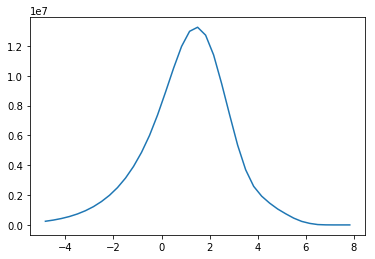

In [36]:
plt.plot(log_bins_centres,sum(combined_numbers)*log_weighted_density)
plt.plot(log_bins_centres,sum(combined_numbers_new)*log_weighted_density_new)
plt.legend(('old normalised to total','new normalised to total'))
plt.title('better normalisation: area under the curve proportional to total')
plt.xlabel('bin value')
plt.ylabel('total contribution/doubling')
plt.xticks(np.log2([0.125,0.25,0.5,1,2,4,8,16,32,64]))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_log2))
plt.xlim(log_bins_min,log_bins_max)
plt.ylim(0,1.5*np.nanmax(sum(combined_numbers_new)*log_weighted_density_new))
plt.show()

In [20]:
number_many_linear_bins=20 # Number of bins for improved plots with equal bins
power_for_unequal_bins=3.0 # Power used for generating unequal bins
number_unequal_bins=40 # Number of unequal bins 
unequal_min=0. # Must be zero or bigger for this approach to work
unequal_max=1.01*np.nanmax(combined_numbers) # Ensure this is greater than the largest number
# N-th root (e.g. third root) of bin edges for manual bin edge spacing
unequal_linspace=np.linspace(unequal_min,unequal_max**(1.0/power_for_unequal_bins),number_unequal_bins) 
unequal_bin_edges=unequal_linspace**power_for_unequal_bins
# This piece of codes calculates the bin centres, based on the third root
# Alternative choice would be: power_bin_centres=0.5*(unequal_bin_edges[:-1]+unequal_bin_edges[1:])
unequal_linspace_centres=0.5*(unequal_linspace[:-1]+unequal_linspace[1:])
unequal_bin_centres=(unequal_linspace_centres)**3
total_nr_draws=len(combined_numbers)

In [14]:
def extend_histogram(values,bin_edges,cumulative=False):
    if cumulative==True:
        return np.concatenate(([0.0],values,[values[-1]])),np.concatenate((bin_edges,[bin_edges[-1]]))      
    else:
        return np.concatenate(([0.0],values,[0.0])),np.concatenate((bin_edges,[bin_edges[-1]]))

In [24]:
np.nanmax(model_data_overlap)
model_data_overlap = model_data_overlap[~np.isnan(model_data_overlap)]
# Keep only wet values 
model_data_overlap = model_data_overlap[model_data_overlap >= 0.1]

In [26]:
np.nanmin(model_data_overlap)

0.10000000894069672

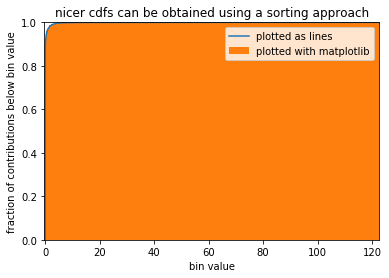

In [32]:
# unequal_counts,bins_out=np.histogram(combined_numbers,bins=unequal_bin_edges) 
# unequal_cumulative=np.cumsum(unequal_counts)/(1.0*total_nr_draws)
# unequal_cumulative_extended,unequal_bin_edges_extended=extend_histogram(unequal_cumulative,unequal_bin_edges,cumulative=True)
# sorted_numbers = np.sort(combined_numbers)
# sorted_numbers_extended=np.concatenate(([sorted_numbers[0]],sorted_numbers)) # repeat first number as zero entry
# relative_ranks=np.arange(total_nr_draws+1.0)/(1.0*total_nr_draws)
# exceedance_ranks=1.0-relative_ranks

# plt.plot(unequal_bin_edges_extended,unequal_cumulative_extended)
# # plt.step(unequal_bin_edges_extended,unequal_cumulative_extended,where='pre')
# # plt.hist(combined_numbers,bins=unequal_bin_edges,cumulative=True,density=True)
# plt.legend(('plotted as lines','plotted as steps','plotted with matplotlib'))
# plt.title('instead of pdfs, plot cumulative distributions (lines meet at right of bar)')
# plt.xlabel('bin value')
# plt.ylabel('fraction of contributions below bin value')
# plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
# # plt.ylim(0,1.0)
# plt.show()

plt.plot(sorted_numbers_extended,relative_ranks)
plt.hist(combined_numbers,bins=unequal_bin_edges,cumulative=True,density=True)
plt.legend(('plotted as lines','plotted with matplotlib'))
plt.title('nicer cdfs can be obtained using a sorting approach')
plt.xlabel('bin value')
plt.ylabel('fraction of contributions below bin value')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,1.0)
plt.show()

# plt.plot(sorted_numbers_extended,exceedance_ranks)
# plt.title('probability of exceedance (1-cdf value)')
# plt.xlabel('bin value')
# plt.ylabel('probability of exceedance')
# plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
# plt.ylim(0,1.0)
# plt.show()

# plt.plot(sorted_numbers_extended,exceedance_ranks)
# plt.scatter(sorted_numbers_extended,exceedance_ranks)
# plt.legend(('plotted as lines','plotted as a scatterplot'))
# plt.title('using a y-log axis')
# plt.xlabel('bin value')
# plt.ylabel('probability of exceedance')
# plt.gca().set_yscale('log')
# plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
# plt.ylim(1e-5,1.0)
# plt.show()

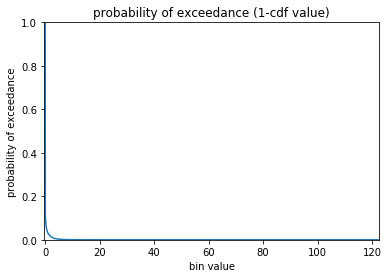

In [33]:
plt.plot(sorted_numbers_extended,exceedance_ranks)
plt.title('probability of exceedance (1-cdf value)')
plt.xlabel('bin value')
plt.ylabel('probability of exceedance')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,1.0)
plt.show()

In [34]:
x= obs_data_no_overlap

In [50]:
# obs_data_no_overlap = np.sort(obs_data_no_overlap)
# obs_data_no_overlap

# obs_data_no_overlap = obs_data_no_overlap[~np.isnan(obs_data_no_overlap)]
x = model_data_no_overlap

In [51]:
n_bins = 8

### Plot for each ensemble member separately

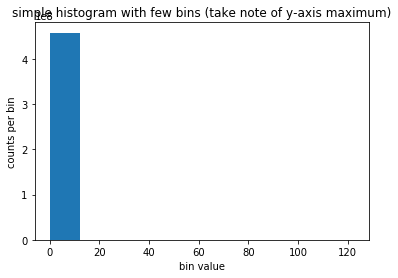

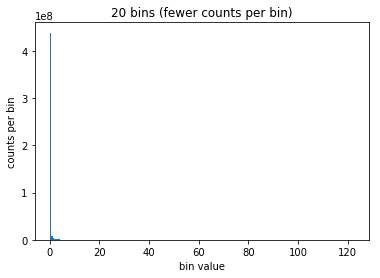

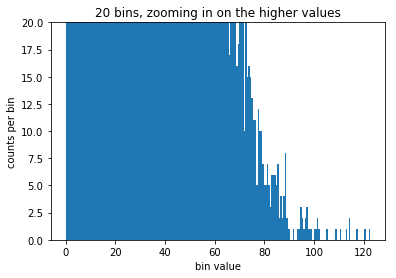

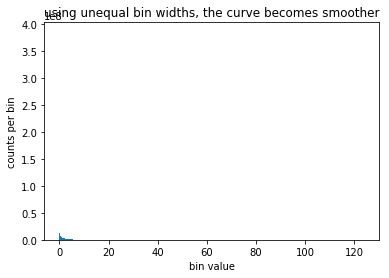

In [29]:
plt.hist(combined_numbers)
plt.title('simple histogram with few bins (take note of y-axis maximum)')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()

plt.hist(combined_numbers,bins=200)
plt.title(str(number_many_linear_bins)+' bins (fewer counts per bin)')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()

# Shows hit-and-miss behaviour for higher values
plt.hist(combined_numbers,bins=200)
plt.title(str(number_many_linear_bins)+' bins, zooming in on the higher values')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.ylim(0,20)
plt.show()

plt.hist(combined_numbers,bins=unequal_bin_edges)
plt.title('using unequal bin widths, the curve becomes smoother')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()


In [47]:
#!/usr/bin/env python
# Steven Boeing, 2020
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# EXAMPLE CODES REGARDING PROBABILITY DISTRIBUTION FUNCTION
# AND CUMULATIVE DISTRIBUTION FUNCTION PLOTTING 

# SMALL NOTES
# 1) This shows some possibilities for plotting, but there are more
# possibilities (e.g. a weighted cumulative distribution function).
# 2) I may want to add something about handling of zero/small values in the
# normalisation procedure at some point. It is something to think about,
# see Nikolina Ban's work.
# 3) I think numpy.histogram and mpl.hist handle numbers that are exactly
# on a bin edge sligthly differently, and it is still possible to improve
# the handling of cases where not all the numbers are in a bin.

# RANDOM NUMBER GENERATION FOR PLOTS
# The seed function is used to make sure you draw the same 'random' 
# numbers each time.
# Draw numbers from a lognormal and from a beta distribution, 
# combine these into a single array
draws_in_each_distribution=10000
np.random.seed(21)
lognormal_numbers=np.random.lognormal(mean=0.3, sigma=1.0, size=draws_in_each_distribution)
beta_numbers=np.random.lognormal(mean=0.3, sigma=0.5, size=draws_in_each_distribution)
combined_numbers=np.concatenate((lognormal_numbers,beta_numbers))
total_nr_draws=len(combined_numbers)

# PARAMETERS FOR PLOTTING HISTOGRAMS
# Parameters to generate bins with unequal spacing
# We use an approach based on the N-th power here 
# (advantage over logarithmic spacing: easy to handle near-zero values)
# An alternative is to use a logarithmmic spacing (see lower down)
number_many_linear_bins=200 # Number of bins for improved plots with equal bins
power_for_unequal_bins=3.0 # Power used for generating unequal bins
number_unequal_bins=40 # Number of unequal bins 
unequal_min=0. # Must be zero or bigger for this approach to work
unequal_max=1.01*np.nanmax(combined_numbers) # Ensure this is greater than the largest number
# N-th root (e.g. third root) of bin edges for manual bin edge spacing
unequal_linspace=np.linspace(unequal_min,unequal_max**(1.0/power_for_unequal_bins),number_unequal_bins) 
unequal_bin_edges=unequal_linspace**power_for_unequal_bins
# This piece of codes calculates the bin centres, based on the third root
# Alternative choice would be: power_bin_centres=0.5*(unequal_bin_edges[:-1]+unequal_bin_edges[1:])
unequal_linspace_centres=0.5*(unequal_linspace[:-1]+unequal_linspace[1:])
unequal_bin_centres=(unequal_linspace_centres)**3

# BEFORE PLOTTING, CHECK MATPLOTLIB VERSION JUST TO SEE WE CAN PLOT EVERYTHING
# USING TUPLES TO AVOID DEPENDECY ON PACKAGES
def versiontuple(v):
    return tuple(map(int, (v.split("."))))
    
if (versiontuple(mpl.__version__)<versiontuple("2.0.0")):
    print 'Error: density histograms need a version of matplotlib>2.0.0'
    print 'You may want to set up and activate an appropriate anaconda environment'
    quit()
    
# SIMPLE HISTOGRAMS
plt.hist(combined_numbers)
plt.title('simple histogram with few bins (take note of y-axis maximum)')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()

plt.hist(combined_numbers,bins=200)
plt.title(str(number_many_linear_bins)+' bins (fewer counts per bin)')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()

# Shows hit-and-miss behaviour for higher values
plt.hist(combined_numbers,bins=200)
plt.title(str(number_many_linear_bins)+' bins, zooming in on the higher values')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.ylim(0,20)
plt.show()

plt.hist(combined_numbers,bins=unequal_bin_edges)
plt.title('using unequal bin widths, the curve becomes smoother')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()

# INTRODUCING THE DENSITY ARGUMENT
# Motivation
plt.hist(combined_numbers,bins=200,histtype='step')
plt.hist(combined_numbers,bins=unequal_bin_edges,histtype='step')
plt.legend((str(number_many_linear_bins)+' equal bins',str(number_unequal_bins)+' unequal bins'))
plt.title('caution: unequal bins influence shape of the curve (histtype=\'step\')')
plt.xlabel('bin value')
plt.ylabel('counts per bin')
plt.show()

plt.hist(combined_numbers,histtype='step',density=True)
plt.hist(combined_numbers,bins=200,histtype='step',density=True)
plt.hist(combined_numbers,bins=unequal_bin_edges,histtype='step',density=True)
plt.legend(('few bins',str(number_many_linear_bins)+' equal bins',str(number_unequal_bins)+' unequal bins'))
plt.title('use \'density\' argument to normalise y-axis (area under each curve is 1)')
plt.xlabel('bin value')
plt.ylabel('density of counts (area under curve is 1)')
plt.ylim(0,0.6)
plt.show()

plt.hist(combined_numbers,histtype='step',density=True)
plt.hist(combined_numbers,bins=200,histtype='step',density=True)
plt.hist(combined_numbers,bins=unequal_bin_edges,histtype='step',density=True)
plt.legend(('few bins',str(number_many_linear_bins)+' equal bins',str(number_unequal_bins)+' unequal bins'))
plt.title('zooming in on the distributions with the \'density\' argument')
plt.xlabel('bin value')
plt.ylabel('density of counts (area under curve is 1)')
plt.ylim(0,0.01)
plt.show()

# NUMPY CALCULATIONS OF HISTOGRAM
# Use extended arrays to get edges right using matplotlib.pyplot.step
# Check manual plots against matplotlib.pyplot.hist
# In the examples below, the 'where' argument is added explicitly
# For the cumulative distribution functions, add extra bin equal to last value
def extend_histogram(values,bin_edges,cumulative=False):
    if cumulative==True:
        return np.concatenate(([0.0],values,[values[-1]])),np.concatenate((bin_edges,[bin_edges[-1]]))      
    else:
        return np.concatenate(([0.0],values,[0.0])),np.concatenate((bin_edges,[bin_edges[-1]]))
    
unequal_density,bins_out=np.histogram(combined_numbers,bins=unequal_bin_edges,density=True)
unequal_density_extended,unequal_bin_edges_extended=extend_histogram(unequal_density,unequal_bin_edges)

# PLOTS TO CHECK MANUALLY PLOTTED HISTOGRAMS AGAINST MATPLOTLIB ONES
plt.plot(unequal_bin_centres,unequal_density)
plt.step(unequal_bin_edges_extended,unequal_density_extended,where='pre') 
plt.hist(combined_numbers,bins=unequal_bin_edges,density=True)
plt.legend(('plotted as lines','plotted as steps','plotted with matplotlib'))
plt.title('you can plot as lines as well (needs some more code)')
plt.xlabel('bin value')
plt.ylabel('density of counts (area under curve is 1)')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,0.6)
plt.show()

plt.plot(unequal_bin_centres,unequal_density)
plt.step(unequal_bin_edges_extended,unequal_density_extended,where='pre')
plt.hist(combined_numbers,bins=unequal_bin_edges,density=True)
plt.legend(('plotted as lines','plotted as steps','plotted with matplotlib'))
plt.title('zooming in on smaller values')
plt.xlabel('bin value')
plt.ylabel('density of counts (area under curve is 1)')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,0.01)
plt.show()

# For the logarithmic plots, add scatterplot option
# Drawback of this plot is that the area under the curve no longer
# corresponds to anything
plt.plot(unequal_bin_centres,unequal_density)
plt.step(unequal_bin_edges_extended,unequal_density_extended,where='pre')
plt.scatter(unequal_bin_centres,unequal_density)
plt.hist(combined_numbers,bins=unequal_bin_edges,density=True)
plt.legend(('plotted as lines','plotted as steps','plotted as scatterplot','plotted with matplotlib'))
plt.title('using a y log-axis')
plt.xlabel('bin value')
plt.ylabel('density of counts (log axis)')
plt.gca().set_yscale('log')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(1e-5,1.0)
plt.show()

plt.plot(unequal_bin_centres,unequal_density)
plt.step(unequal_bin_edges_extended,unequal_density_extended,where='pre')
plt.scatter(unequal_bin_centres,unequal_density)
plt.hist(combined_numbers,bins=unequal_bin_edges,density=True)
plt.legend(('plotted as lines','plotted as steps','plotted as scatterplot','plotted with matplotlib'))
plt.title('using two log axes')
plt.xlabel('bin value (log axis)')
plt.ylabel('density of counts (log axis)')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim(1e-3,np.nanmax(combined_numbers))
plt.ylim(1e-5,1.0)
plt.show()

# CUMULATIVE HISTOGRAM PLOTTING
# Including manual normalisation
# Extended arrays used to make cdf go from 0 to non-zero at first value in line plot
# Another (nicer) way to create cdfs involves sorting the array to obtain relative ranks
# this is also demonstrated
unequal_counts,bins_out=np.histogram(combined_numbers,bins=unequal_bin_edges) 
unequal_cumulative=np.cumsum(unequal_counts)/(1.0*total_nr_draws)
unequal_cumulative_extended,unequal_bin_edges_extended=extend_histogram(unequal_cumulative,unequal_bin_edges,cumulative=True)
sorted_numbers = np.sort(combined_numbers)
sorted_numbers_extended=np.concatenate(([sorted_numbers[0]],sorted_numbers)) # repeat first number as zero entry
relative_ranks=np.arange(total_nr_draws+1.0)/(1.0*total_nr_draws)
exceedance_ranks=1.0-relative_ranks

plt.plot(unequal_bin_edges_extended,unequal_cumulative_extended)
plt.step(unequal_bin_edges_extended,unequal_cumulative_extended,where='pre')
plt.hist(combined_numbers,bins=unequal_bin_edges,cumulative=True,density=True)
plt.legend(('plotted as lines','plotted as steps','plotted with matplotlib'))
plt.title('instead of pdfs, plot cumulative distributions (lines meet at right of bar)')
plt.xlabel('bin value')
plt.ylabel('fraction of contributions below bin value')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,1.0)
plt.show()

plt.plot(sorted_numbers_extended,relative_ranks)
plt.hist(combined_numbers,bins=unequal_bin_edges,cumulative=True,density=True)
plt.legend(('plotted as lines','plotted with matplotlib'))
plt.title('nicer cdfs can be obtained using a sorting approach')
plt.xlabel('bin value')
plt.ylabel('fraction of contributions below bin value')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,1.0)
plt.show()

plt.plot(sorted_numbers_extended,exceedance_ranks)
plt.title('probability of exceedance (1-cdf value)')
plt.xlabel('bin value')
plt.ylabel('probability of exceedance')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,1.0)
plt.show()

plt.plot(sorted_numbers_extended,exceedance_ranks)
plt.scatter(sorted_numbers_extended,exceedance_ranks)
plt.legend(('plotted as lines','plotted as a scatterplot'))
plt.title('using a y-log axis')
plt.xlabel('bin value')
plt.ylabel('probability of exceedance')
plt.gca().set_yscale('log')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(1e-5,1.0)
plt.show()

# WEIGHTED DENSITY HISTOGRAMS
# Rather than probability in each bin, these show the contribution to the
# sum of the numbers corresponding to each bin.
weighted_density,bins_out=np.histogram(combined_numbers,bins=unequal_bin_edges,density=True,weights=combined_numbers)
weighted_density_extended,unequal_bin_edges_extended=extend_histogram(weighted_density,unequal_bin_edges)
  
plt.plot(unequal_bin_centres,weighted_density)
plt.step(unequal_bin_edges_extended,weighted_density_extended,where='pre')
plt.hist(combined_numbers,bins=unequal_bin_edges,density=True,weights=combined_numbers)
plt.legend(('plotted as lines','plotted as steps','plotted with matplotlib'))
plt.title('weight the pdf by \'contribution\' to emphasize high bin values')
plt.xlabel('bin value')
plt.ylabel('density of contributions (area under curve is 1)')
plt.xlim(-0.003*np.nanmax(combined_numbers),np.nanmax(combined_numbers))
plt.ylim(0,0.35)
plt.show()

# PLOTS WITH LOGARITHMIC BINS
# formatting for powers of two
def format_log2(value, tick_number):
    N = 2.0**value
    return r"${0}$".format(N)
    
log_bins=40
log_bins_min=-5.
log_bins_max=8
log_bins_linspace=np.linspace(log_bins_min,log_bins_max,log_bins)
log_bins_centres=0.5*(log_bins_linspace[:-1]+log_bins_linspace[1:])
log_weighted_density,bins_out=np.histogram(np.log2(combined_numbers),bins=log_bins_linspace,density=True,weights=combined_numbers)
log_weighted_density_extended,log_bin_edges_extended=extend_histogram(log_weighted_density,log_bins_linspace)
    
plt.plot(log_bins_centres,log_weighted_density)
plt.step(log_bin_edges_extended,log_weighted_density_extended,where='pre') 
plt.legend(('plotted as lines','plotted as steps'))
plt.title('log x-axis and logarithmic bins (area below curve scales with contribution)')
plt.ylim(0,0.5)
plt.xlim(log_bins_min,log_bins_max)
plt.xticks(np.log2([0.125,0.25,0.5,1,2,4,8,16,32,64]))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_log2))
plt.xlabel('bin value')
plt.ylabel('density of contributions/doubling')
plt.show()

# GENERATE A SECOND DISTRIBUTION
lognormal_numbers_new=np.random.lognormal(mean=0.4, sigma=1.2, size=draws_in_each_distribution)
beta_numbers_new=np.random.lognormal(mean=0.4, sigma=0.6, size=draws_in_each_distribution)
combined_numbers_new=np.concatenate((lognormal_numbers_new,beta_numbers_new))
log_weighted_density_new,bins_out=np.histogram(np.log2(combined_numbers_new),bins=log_bins_linspace,density=True,weights=combined_numbers_new)

# NORMALISED TO HAVE EQUAL AREA UNDER CURVE (AREA IS 1 IF THE "DISTANCE" FOR EACH DOUBLING IS REGARDED AS 1)
plt.plot(log_bins_centres,log_weighted_density)
plt.plot(log_bins_centres,log_weighted_density_new)
plt.legend(('old normalised to unity','new normalised to unity'))
plt.title('similar plot for two different distributions (equal area under curve)')
plt.xlabel('bin value')
plt.ylabel('density of contributions/doubling')
plt.xticks(np.log2([0.125,0.25,0.5,1,2,4,8,16,32,64]))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_log2))
plt.xlim(log_bins_min,log_bins_max)
plt.ylim(0,0.5)
plt.show()

# NORMALISED TO HAVE AREA UNDER CURVE EQUAL TO SUM OF NUMBERS
# For precipitation, this plot has the advantage that it displays both:
# - How the probability and amount of at a given rate (e.g. 30 mm/hr rainfall) changes (both scale as curve height at 30 mm/hr)
# - How the amount of rainfall above a threshold rate (e.g. 30 mm/hr) changes (scales as area of curve above 30 mm/hr)
plt.plot(log_bins_centres,sum(combined_numbers)*log_weighted_density)
plt.plot(log_bins_centres,sum(combined_numbers_new)*log_weighted_density_new)
plt.legend(('old normalised to total','new normalised to total'))
plt.title('better normalisation: area under the curve proportional to total')
plt.xlabel('bin value')
plt.ylabel('total contribution/doubling')
plt.xticks(np.log2([0.125,0.25,0.5,1,2,4,8,16,32,64]))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_log2))
plt.xlim(log_bins_min,log_bins_max)
plt.ylim(0,1.5*np.nanmax(sum(combined_numbers_new)*log_weighted_density_new))
plt.show()
